In [18]:
import yfinance as yf
import pandas as pd
from darts import TimeSeries
import itertools
import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, TFTModel, NBEATSModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

#### Loading data from yahoo

In [2]:
def load_data():
    id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
    ticker_to_name_path = "Datasets/kaggle/Company.csv"

    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)
    tickers = company_name_df.ticker_symbol.tolist()

    market_data = yf.download((' ').join(tickers), start="2015-01-01", end="2020-01-01", group_by = 'ticker')

    returns = pd.DataFrame()

    for ticker in market_data.columns.levels[0]:
        returns[ticker] = market_data[ticker].Close.shift(-1).dropna()

    market_data = market_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    market_data = market_data.dropna()
    market_data = market_data.reset_index()

    market_data.to_csv('Datasets/market/market.csv', index=False)

    return market_data

In [3]:
data = load_data()

[*********************100%***********************]  6 of 6 completed


#### Below i change the date format. This way i remove the gaps between holidays and weekends which are meaningless for our data, but the TimeSeries asks to impute them and treats as a missing values.

In [4]:
for i, j in itertools.product(range(0, 7548, 6), range(6)):
    data.loc[i+j, 'Date'] = i and int(i / 6) or 0

data.Date = data.Date.astype('int')

In [5]:
data.head(10)

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,0,AAPL,24.603205,27.332500,27.860001,26.837500,27.847500,212818400
1,0,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000
2,0,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268
3,0,GOOGL,26.477501,26.477501,26.790001,26.393999,26.629999,26480000
4,0,MSFT,40.811428,46.759998,47.419998,46.540001,46.660000,27913900
5,0,TSLA,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
6,1,AAPL,23.910097,26.562500,27.162500,26.352501,27.072500,257142000
7,1,AMZN,15.109500,15.109500,15.419000,15.042500,15.350500,55484000
8,1,GOOG,25.623152,25.623152,26.144720,25.582764,26.091366,41196796
9,1,GOOGL,25.973000,25.973000,26.399500,25.887501,26.357500,41182000


#### Data exctraction. We will use only daily Close value in our timeseries.


6 series were extracted from the input DataFrame
Static covariates of series 0
static_covariates Ticker
component               
Close               AAPL
Static covariates of series 1
static_covariates Ticker
component               
Close               AMZN
Static covariates of series 2
static_covariates Ticker
component               
Close               GOOG
Static covariates of series 3
static_covariates Ticker
component               
Close              GOOGL
Static covariates of series 4
static_covariates Ticker
component               
Close               MSFT
Static covariates of series 5
static_covariates Ticker
component               
Close               TSLA


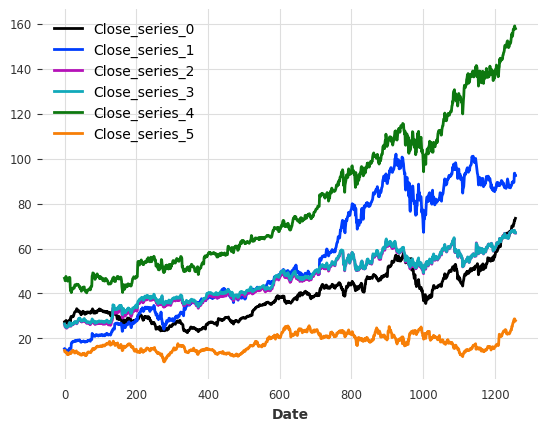

In [6]:
series_multi = TimeSeries.from_group_dataframe(
    data,
    time_col="Date",
    group_cols="Ticker",  # individual time series are extracted by grouping `df` by `group_cols`
    static_cols=[],
    value_cols=[
        # "Adj Close",
        "Close",
        # "High",
        # "Low",
        # "Open"
    ],  # optionally, specify the time varying columns which are extracted
)

print(f"\n{len(series_multi)} series were extracted from the input DataFrame")
for i, ts in enumerate(series_multi):
    print(f"Static covariates of series {i}")
    print(ts.static_covariates)
    ts["Close"].plot(label=f"Close_series_{i}")

#### We split our series in tran, test and val and scale individually on train set

In [7]:
train_series = []
val_series = []
test_series = []
total_series = []
transformers = [Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()]

for i, series in enumerate(series_multi):
    train, val = series.split_before(900) # train / val split
    val, test = val.split_before(1100) # val / test split

    train = transformers[i].fit_transform(train) # fit on train
    val = transformers[i].transform(val)
    test = transformers[i].transform(test)
    total = transformers[i].transform(series)

    train_series.append(train)
    val_series.append(val)
    test_series.append(test)
    total_series.append(total)

In [8]:
def plot_backtest(model, idx=0, start=900, horizon=3):
    backtest_series = model.historical_forecasts(
    total_series[idx],
    start=start,
    forecast_horizon=horizon,
    retrain=False,
    verbose=False
    )

    plt.figure(figsize=(8, 5))
    transformers[idx].inverse_transform(total_series[idx])['Close'][start:].plot(label="actual")
    transformers[idx].inverse_transform(backtest_series)['Close'].plot(label="backtest")
    plt.legend()
    mape_loss = mape(transformers[idx].inverse_transform(total_series[idx]), transformers[idx].inverse_transform(backtest_series))
    plt.title(f"Backtest, starting day {start} with horizon {horizon} - mape {mape_loss:.2f} %")

# RNN LSTM model

In [ ]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode='min',
)

my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Price_RNN_LSTM_30",
    log_tensorboard=True,
    random_state=42,
    training_length=60,
    input_chunk_length=30, # number of steps before prediction
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "callbacks": [my_stopper],
      "enable_progress_bar": False
    }
)

my_model.fit(
    train_series,
    val_series=val_series,
    verbose=True,
)

In [10]:
best_model = RNNModel.load_from_checkpoint(model_name="Price_RNN_LSTM_30", best=True)

## AMAZON

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 -

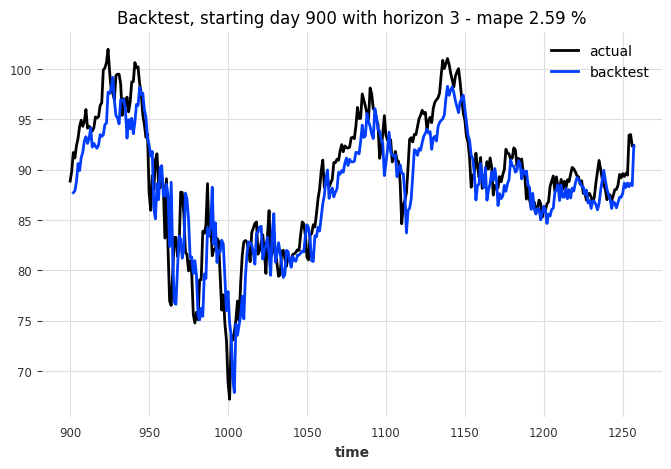

In [11]:
plot_backtest(
    model=best_model,
    idx=1,
    start=900,
    horizon=3
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

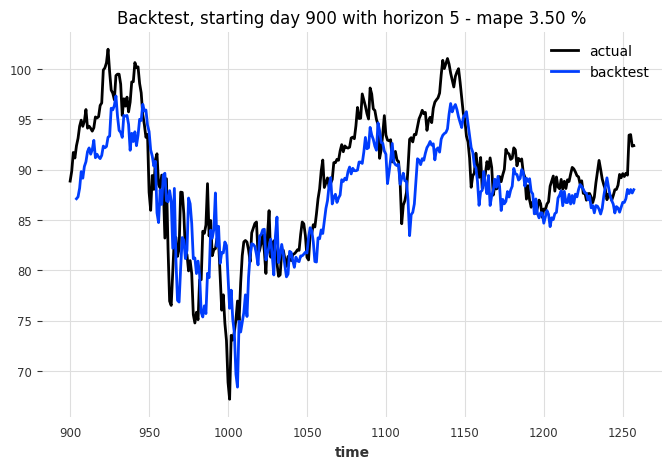

In [12]:
plot_backtest(
    model=best_model,
    idx=1,
    start=900,
    horizon=5
)

## TSLA

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

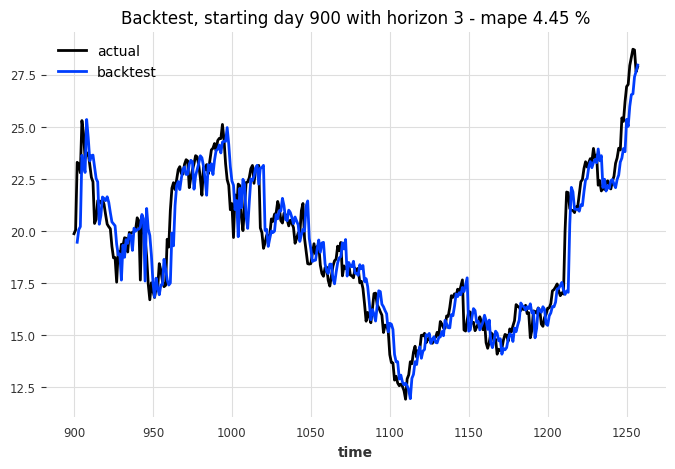

In [13]:
plot_backtest(
    model=best_model,
    idx=5,
    start=900,
    horizon=3
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

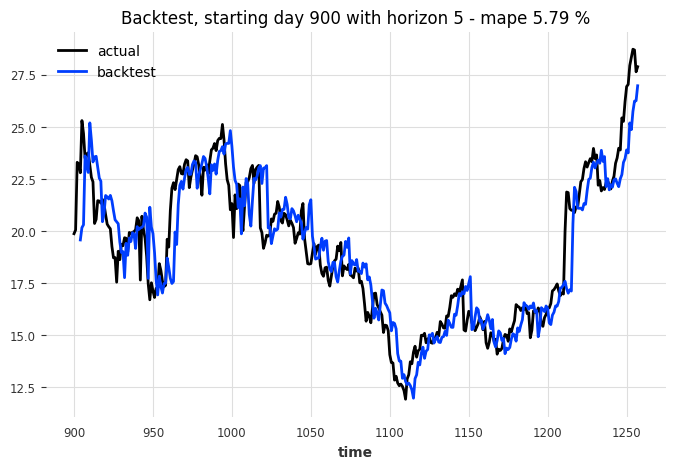

In [14]:
plot_backtest(
    model=best_model,
    idx=5,
    start=900,
    horizon=5
)

# Nbeats model

In [ ]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    mode='min',
)

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=5,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=16,
    save_checkpoints=True,
    force_reset=True,
    model_name="Price_Nbeats_30",
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "callbacks": [my_stopper],
      "enable_progress_bar": False
    }
)

model_nbeats.fit(
    train_series,
    val_series=val_series,
    verbose=True,
)

In [28]:
best_model = RNNModel.load_from_checkpoint(model_name="Price_Nbeats_30", best=True)

## AMAZON

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 -

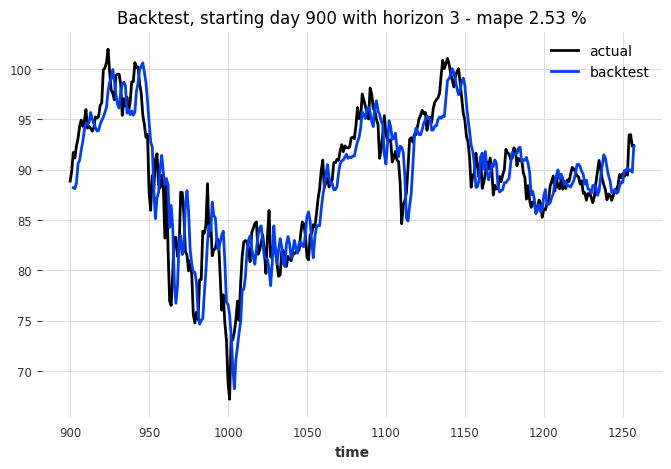

In [29]:
plot_backtest(
    model=best_model,
    idx=1,
    start=900,
    horizon=3
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

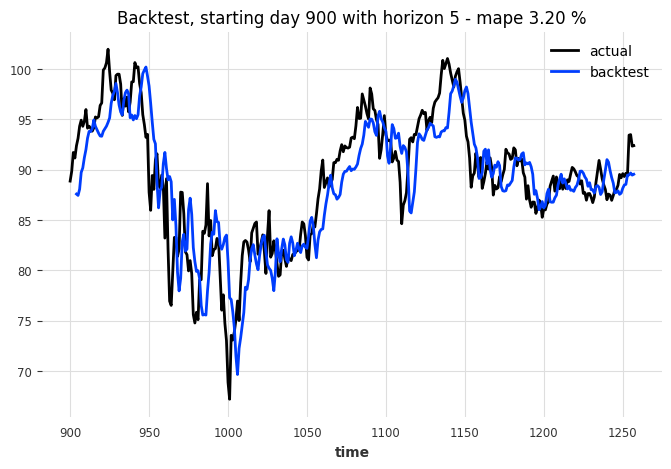

In [30]:
plot_backtest(
    model=best_model,
    idx=1,
    start=900,
    horizon=5
)

## TESLA

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

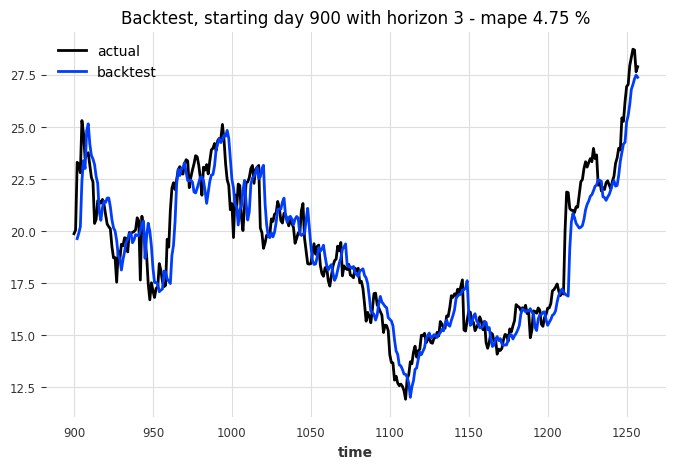

In [31]:
plot_backtest(
    model=best_model,
    idx=5,
    start=900,
    horizon=3
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

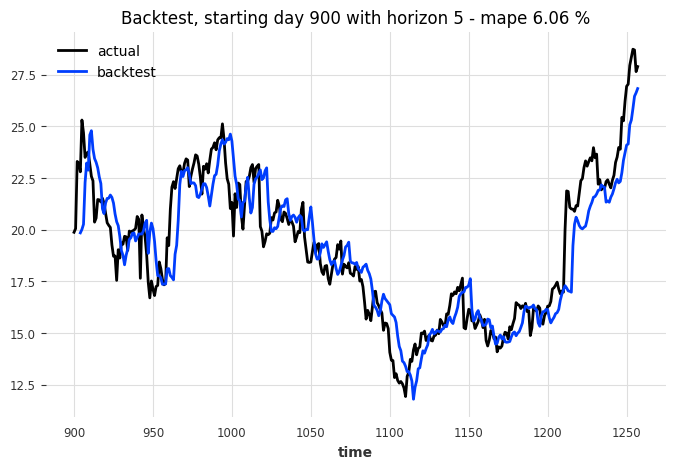

In [32]:
plot_backtest(
    model=best_model,
    idx=5,
    start=900,
    horizon=5
)